In [144]:
# # MNIST Digit Classification - Présentation
# 
# Ce notebook présente les résultats finaux de mon projet de classification de chiffres manuscrits
# sur le dataset MNIST. 
# 
# **Objectif** : entraîner un modèle (MLP ou CNN) pour reconnaître les chiffres (0-9).
# 
# **Résumé** :
# - Dataset : MNIST (60k images train, 10k images test, 28×28 pixels, grayscale)
# - Modèles testés : MLP amélioré, CNN type LeNet
# - Meilleur modèle : CNN avec Dropout + BatchNorm


### 1. Tableau récapitulatif des modèles
| Modèle | Accuracy Test (%) | Epoch du max | Data_augmentation | Dropout | BatchNorm | Temps d'entraînement(min) |
|--------|------------------|-----------|------------|---------|-----------|----------------------|
| Adam_base | 99.34 | 17 | Non | Non | Non | 11:52 |
| Sgd_base | 99.29 | 14 | Non | Non | Non | 10:17 |
| Rmsprop | 99.3 | 11 | Non | Non | Non | 12:12 |
| Sgd_best_wo_data_augment | 99.39 | 5 | Non | Oui | Oui | 9:42 |
| Sgd_best_wo_batchnorm | 99.52 | 10 | Non | Oui | Non | 27:00 |
| Sgd_best_wo_dropout | 99.58 | 19 | Oui | Non | Oui | 31:08 |
| Sgd_best | 99.59 | 9 | Oui | Oui | Oui | 21:42 |

### 2. Courbes comparatives  
- **Best Optim Comparatifs**  
- **Optimizers comparatifs**
![A](../outputs/plots/base_models_compare_optimizer.png)
![B](../outputs/plots/best_compares.png)

### 3. Analyse des résultats
- **Technique la plus efficace** : L'optimizer SGD est celui qui a été le plus efficace dans les optimizer de base c'est pour cela que l'on a utilisé pour l'affinage du modèle    
- **Points faibles / Surapprentissage** : On peut voir que il y a de l'overfitting quand il n'y a pas de data augmentation et le meilleure modèle nous donne un rendu plus lise a l'apprentissage 

# --- Imports ---

In [145]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from scripts.mnist_dataloader import MNISTDataLoader

# --- Config pour trouver les modules du projet ---

In [146]:
import sys
from pathlib import Path

root_dir = Path().resolve().parent
sys.path.append(str(root_dir))

# --- Chargement du modèle ---

In [147]:
from scripts.neural_net import NeuralNet  # Adapter selon ton fichier
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = NeuralNet()
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
model.load_state_dict(torch.load("../models/model_sgd_best.pth", map_location=device))
model.to(device)
model.eval()

NeuralNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

# --- Dataset test ---

In [148]:
from scripts.mnist_dataloader import MNISTDataLoader

loader = MNISTDataLoader()
loader.setup()
train_loader = loader.train_dataloader()
test_loader = loader.test_dataloader()

# --- Fonction affichage ---

In [149]:
def imshow(img, label, pred):
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Label: {label} | Pred: {pred}")
    plt.axis("off")

    plt.show()


# --- Prédictions sur quelques images du dataset---

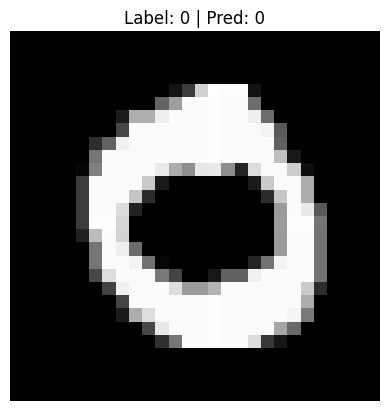

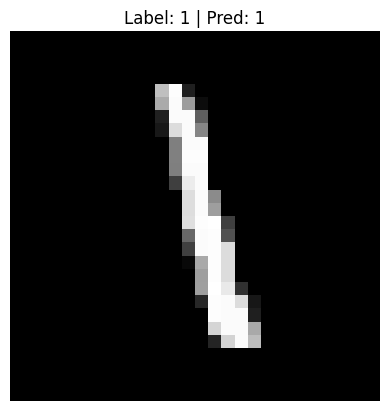

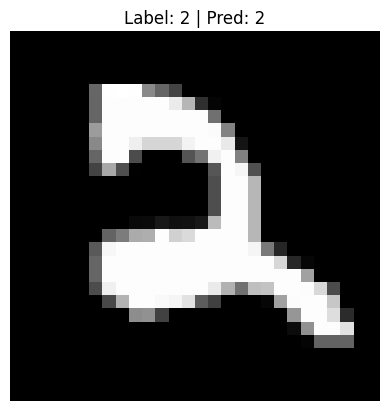

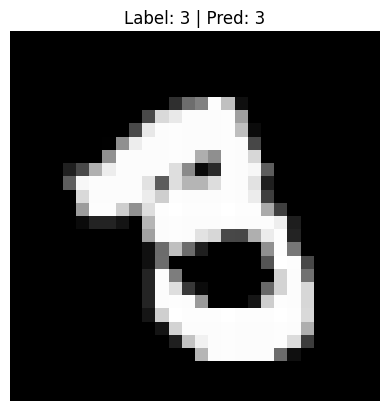

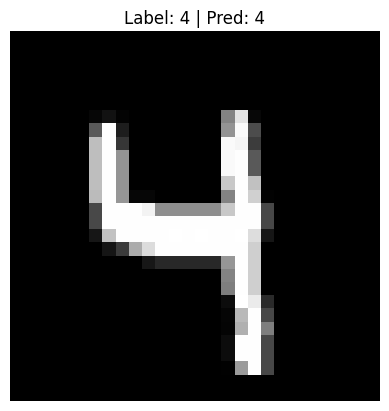

In [150]:

import random

# Créer un itérateur aléatoire
random_batch_idx = random.randint(0, len(test_loader)-1)
for i, (images, labels) in enumerate(test_loader):
    if i == random_batch_idx:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for j in range(5):
            imshow(images[j].cpu(), labels[j].item(), preds[j].item())
        break


# --- Prédictions sur quelques images fait mains---


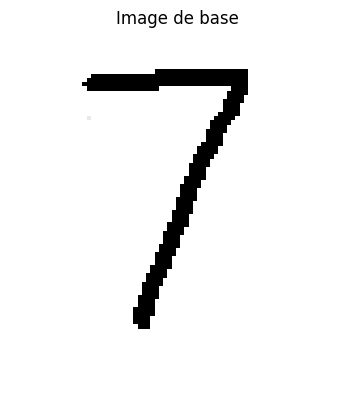

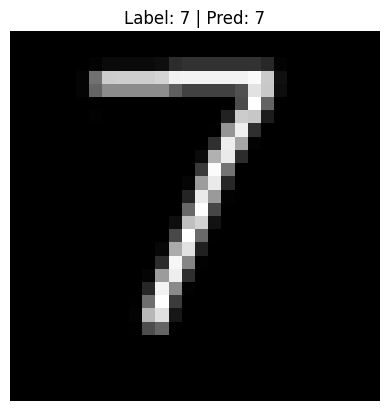

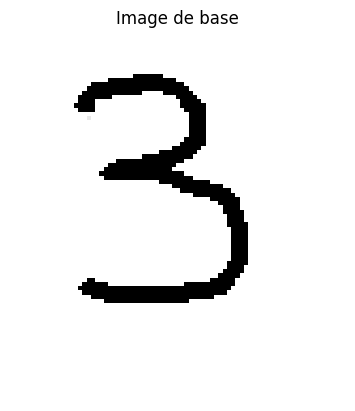

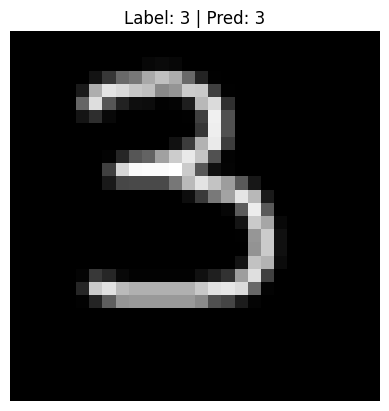

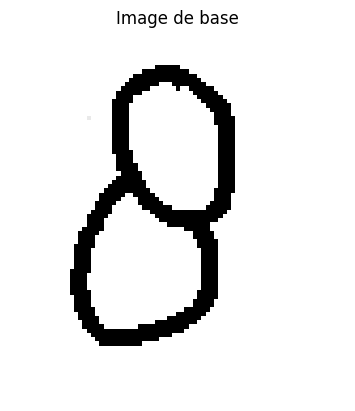

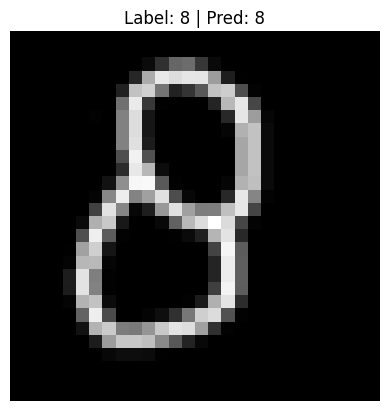

In [151]:
from PIL import Image
from PIL import ImageOps



def predict_and_show(image_path, true_label, model, device):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title("Image de base")
    plt.axis("off")
    plt.show()
    
    img = ImageOps.invert(img)
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1, keepdim=True)
        imshow(img.cpu(), true_label, pred.item())


predict_and_show("../test/sept.png", "7", model, device)
predict_and_show("../test/trois.png", "3", model, device)
predict_and_show("../test/huit.png", "8", model, device)

# --- Matrice de confusion ---

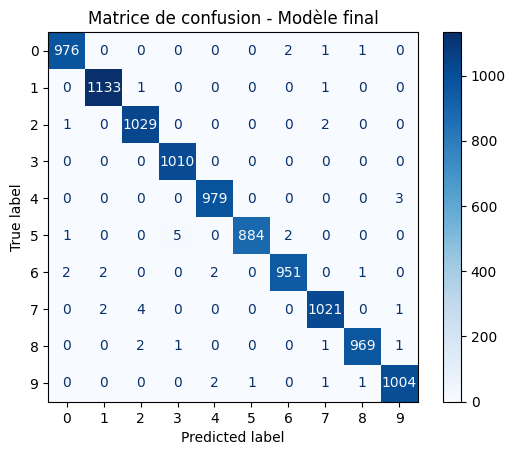

In [152]:
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="Blues")
plt.title("Matrice de confusion - Modèle final")
plt.show()

# --- Résultats ---

In [153]:
accuracy = np.mean(np.array(all_preds) == np.array(all_labels)) * 100
print(f"Accuracy finale : {accuracy:.2f}%")

print("Chiffres les plus confondus :")
for i in range(10):
    # On met la diagonale à -1 pour ignorer les prédictions correctes
    cm[i, i] = -1
    
    # Trouver l'index du chiffre le plus souvent confondu avec i
    worst_pred = np.argmax(cm[i])
    count = cm[i][worst_pred]
    
    if count > 0:
        print(f"{i} → {worst_pred} ({count} fois)")
    else:
        print(f"{i} : aucune confusion")

Accuracy finale : 99.56%
Chiffres les plus confondus :
0 → 6 (2 fois)
1 → 2 (1 fois)
2 → 7 (2 fois)
3 : aucune confusion
4 → 9 (3 fois)
5 → 3 (5 fois)
6 → 0 (2 fois)
7 → 2 (4 fois)
8 → 2 (2 fois)
9 → 4 (2 fois)
